# Neural Machine Translation

We build a neural machine translation system using modern techniques for sequence-to-sequence modeling. We first implement a baseline encoder-decoder architecture, then improve upon the baseline by adding an attention mechanism and implementing beam search. The end result is a fully functional translation system capable of translating simple German sentences into English. This project is part of the *CS288 - AI for Natural Language Processing* class at University of California, Berkeley.

## Setup

First we install and import the required dependencies. These include:
* `torch` for modeling and training
* `torchtext` for data collection
* `sentencepiece` for subword tokenization
* `sacrebleu` for BLEU score evaluation

In [ ]:
%%capture
!pip install --upgrade sacrebleu sentencepiece torch torchtext tqdm

# Standard library imports
import json
import math
import random

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import sacrebleu
import sentencepiece
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import tqdm.notebook

Before proceeding, let's verify that we're connected to a GPU runtime and that `torch` can detect the GPU.

In [2]:
assert torch.cuda.is_available()
device = torch.device("cuda")
print("Using device:", device)

Using device: cuda


## Data

The data for this assignment comes from the [Multi30K dataset](https://arxiv.org/abs/1605.00459), which contains English and German captions for images from Flickr. We can download and unpack it using `torchtext`. We use the Multi30K dataset because it is simpler than standard translation benchmark datasets and allows for models to be trained and evaluated in a matter of minutes rather than days.

In [3]:
extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root=".")

training.tar.gz:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 6.83MB/s]
validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.75MB/s]

downloading validation.tar.gz
downloading mmt_task1_test2016.tar.gz



mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.65MB/s]


## Vocabulary

We can use `sentencepiece` to create a joint German-English subword vocabulary from the training corpus. Because the number of training examples is small, we choose a smaller vocabulary size than would be used for large-scale Neural Machine Translation.

In [5]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "multi30k/train.de,multi30k/train.en",
    "vocab_size": 8000,
    "model_prefix": "multi30k",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

True

This creates two files: `multi30k.model` and `multi30k.vocab`. The first is a binary file containing the relevant data for the vocabulary. The second is a human-readable listing of each subword and its associated score.

The vocabulary consists of four special tokens (`<pad>` for padding, `<s>` for beginning of sentence (BOS), `</s>` for end of sentence (EOS), `<unk>` for unknown) and a mixture of German and English words and subwords.

To use the vocabulary, we first need to load it from the binary file produced above.

In [7]:
vocab = sentencepiece.SentencePieceProcessor()
vocab.Load("multi30k.model")

True

The vocabulary object includes a number of methods for working with full sequences or individual pieces. A complete interface can be found on [GitHub](https://github.com/google/sentencepiece/tree/master/python#usage) for reference.

We define some constants here for the first three special tokens that will become useful in the following sections.

In [ ]:
pad_id = vocab.PieceToId("<pad>")
bos_id = vocab.PieceToId("<s>")
eos_id = vocab.PieceToId("</s>")

Note that these tokens will be stripped from the output when converting from word pieces to text. This will be helpful when implementing greedy search and beam search.

## Baseline sequence-to-sequence model

With our data and vocabulary loaded, we're now ready to build a baseline sequence-to-sequence model.  Later on we'll add an attention mechanism to the model.

Let's begin by defining a batch iterator for the training data. Given a dataset and a batch size, it will iterate over the dataset and yield pairs of tensors containing the subword indices for the source and target sentences in the batch, respectively.

In [11]:
def make_batch(sentences):
    """Convert a list of sentences into a batch of subword indices.

    Args:
        sentences: A list of sentences, each of which is a string.

    Returns:
        A LongTensor of size (max_sequence_length, batch_size) containing the
        subword indices for the sentences, where max_sequence_length is the length
        of the longest sentence as encoded by the subword vocabulary and batch_size
        is the number of sentences in the batch. A beginning-of-sentence token
        should be included before each sequence, and an end-of-sentence token should
        be included after each sequence. Empty slots at the end of shorter sequences
        should be filled with padding tokens. The tensor should be located on the
        device defined at the beginning of the notebook.
    """
    sequences = [torch.tensor([bos_id] + vocab.EncodeAsIds(sentence) + [eos_id]) for sentence in sentences]
    sequences = nn.utils.rnn.pad_sequence(sequences, padding_value = pad_id, batch_first = False)
    sequences = torch.tensor(sequences, device = device)
    return sequences

def make_batch_iterator(dataset, batch_size, shuffle=False):
    """Make a batch iterator that yields source-target pairs.

    Args:
        dataset: A torchtext dataset object.
        batch_size: An integer batch size.
        shuffle: A boolean indicating whether to shuffle the examples.

    Yields:
        Pairs of tensors constructed by calling the make_batch function on the
        source and target sentences in the current group of examples. The max
        sequence length can differ between the source and target tensor, but the
        batch size will be the same. The final batch may be smaller than the given
        batch size.
    """

    examples = list(dataset)
    if shuffle:
        random.shuffle(examples)

    for start_index in range(0, len(examples), batch_size):
        example_batch = examples[start_index:start_index + batch_size]
        source_sentences = [example.src for example in example_batch]
        target_sentences = [example.trg for example in example_batch]
        yield make_batch(source_sentences), make_batch(target_sentences)

test_batch = make_batch(["a test input", "a longer input than the first"])
print("Example batch tensor:")
print(test_batch)
assert test_batch.shape[1] == 2
assert test_batch[0, 0] == bos_id
assert test_batch[0, 1] == bos_id
assert test_batch[-1, 0] == pad_id
assert test_batch[-1, 1] == eos_id

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Example batch tensor:
tensor([[   1,    1],
        [   5,    5],
        [3980,  352],
        [   6,   60],
        [ 234,    6],
        [ 760,  234],
        [   2,  760],
        [   0, 5335],
        [   0,   13],
        [   0, 3769],
        [   0,    2]], device='cuda:0')


Now we will define the model itself. It should consist of a bidirectional LSTM encoder that encodes the input sentence into a fixed-size representation, and an LSTM decoder that uses this representation to produce the output sentence.

In [ ]:
class Seq2seqBaseline(nn.Module):
  def __init__(self):
    super().__init__()

    vocab_size = vocab.GetPieceSize()
    self.embedding = nn.Embedding(vocab_size, 256)
    self.lstm_encoder = nn.LSTM(256, 256, 2, dropout = 0.5, bidirectional = True)
    self.lstm_decoder = nn.LSTM(256, 256, 2, dropout = 0.5)
    self.linear = nn.Linear(256,vocab_size)

  def encode(self, source):
    """Encode the source batch using a bidirectional LSTM encoder.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.

    Returns:
      A tuple with three elements:
        encoder_output: The output of the bidirectional LSTM with shape
          (max_source_sequence_length, batch_size, 2 * hidden_size).
        encoder_mask: A boolean tensor with shape (max_source_sequence_length,
          batch_size) indicating which encoder outputs correspond to padding
          tokens. Its elements should be True at positions corresponding to
          padding tokens and False elsewhere.
        encoder_hidden: The final hidden states of the bidirectional LSTM (after
          a suitable projection) that will be used to initialize the decoder.
          This should be a pair of tensors (h_n, c_n), each with shape
          (num_layers, batch_size, hidden_size). Note that the hidden state
          returned by the LSTM cannot be used directly. Its initial dimension is
          twice the required size because it contains state from two directions.

    The first two return values are not required for the baseline model and will
    only be used later in the attention model.
    """

    lengths = torch.sum(source != pad_id, axis=0)

    batch_size = source.shape[1]
    x = self.embedding(source).view(-1, batch_size, 256)
    h_0 = torch.zeros(4, batch_size, 256, device=device)
    c_0 = torch.zeros(4, batch_size, 256, device=device) #have to define on the cuda device or colab will crash
    output, hidden = self.lstm_encoder(x, (h_0, c_0))
    h_n, c_n = hidden
    h_n = h_n[:2,:,:] + h_n[2:,:,:]
    c_n = c_n[:2,:,:] + c_n[2:,:,:]
    mask = torch.zeros_like(source).masked_fill_(source == pad_id, -1e9)
    return output, mask, (h_n, c_n)

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: This will be implemented later in the attention
          model, but in order to maintain compatible type signatures, we also
          include it here.
    """

    # These arguments are not used in the baseline model.
    del encoder_output
    del encoder_mask
    batch_size = decoder_input.shape[1]
    x = self.embedding(decoder_input).view(-1, batch_size, 256)
    x, decoder_hidden = self.lstm_decoder(x, initial_hidden)
    logits = self.linear(x)
    return logits, decoder_hidden, True

  def compute_loss(self, source, target):
    """Run the model on the source and compute the loss on the target.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.
      target: An integer tensor with shape (max_target_sequence_length,
        batch_size) containing subword indices for the target sentences.

    Returns:
      A scalar float tensor representing cross-entropy loss on the current batch.
    """
    vocab_size = vocab.GetPieceSize()
    batch_size = source.shape[1]
    encoder_output, encoder_mask, hidden = self.encode(source)
    decoder_input = target[:-1]
    logits, _, _ = self.decode(decoder_input, hidden, encoder_output, encoder_mask)
    loss = F.cross_entropy(logits.permute(1, 2, 0), target[1:].permute(1,0)) #put batch_size first and vocab_size in the middle or this will prevent training
    return loss.mean()

We define the following functions for training.

In [ ]:
def train(model, num_epochs, batch_size, model_file):
  """Train the model and save its best checkpoint.
  
  Model performance across epochs is evaluated using token-level accuracy on the
  validation set. The best checkpoint obtained during training will be stored on
  disk and loaded back into the model at the end of training.
  """
  optimizer = torch.optim.Adam(model.parameters())
  best_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        make_batch_iterator(training_data, batch_size, shuffle=True),
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=math.ceil(len(training_data) / batch_size)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, (source, target) in enumerate(batch_iterator, start=1):
        optimizer.zero_grad()
        loss = model.compute_loss(source, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_perplexity, validation_accuracy = evaluate_next_token(
          model, validation_data)
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_perplexity=validation_perplexity,
          validation_token_accuracy=validation_accuracy)
      if validation_accuracy > best_accuracy:
        print(
            "Obtained a new best validation accuracy of {:.2f}, saving model "
            "checkpoint to {}...".format(validation_accuracy, model_file))
        torch.save(model.state_dict(), model_file)
        best_accuracy = validation_accuracy
  print("Reloading best model checkpoint from {}...".format(model_file))
  model.load_state_dict(torch.load(model_file))

def evaluate_next_token(model, dataset, batch_size=64):
  """Compute token-level perplexity and accuracy metrics.

  Note that the perplexity here is over subwords, not words.
  
  This function is used for validation set evaluation at the end of each epoch
  and should not be modified.
  """
  model.eval()
  total_cross_entropy = 0.0
  total_predictions = 0
  correct_predictions = 0
  with torch.no_grad():
    for source, target in make_batch_iterator(dataset, batch_size):
      encoder_output, encoder_mask, encoder_hidden = model.encode(source)
      decoder_input, decoder_target = target[:-1], target[1:]
      logits, decoder_hidden, attention_weights = model.decode(
          decoder_input, encoder_hidden, encoder_output, encoder_mask)
      total_cross_entropy += F.cross_entropy(
          logits.permute(1, 2, 0), decoder_target.permute(1, 0),
          ignore_index=pad_id, reduction="sum").item()
      total_predictions += (decoder_target != pad_id).sum().item()
      correct_predictions += (
          (decoder_target != pad_id) &
          (decoder_target == logits.argmax(2))).sum().item()
  perplexity = math.exp(total_cross_entropy / total_predictions)
  accuracy = 100 * correct_predictions / total_predictions
  return perplexity, accuracy

We can now train the baseline model.

Since we haven't yet defined a decoding method to output an entire string, we will measure performance for now by computing perplexity and the accuracy of predicting the next token given a gold prefix of the output.

In [ ]:
num_epochs = 10
batch_size = 16

baseline_model = Seq2seqBaseline().to(device)
train(baseline_model, num_epochs, batch_size, "baseline_model.pt")

We can load a pre-saved model.

In [14]:
baseline_model = Seq2seqBaseline().to(device)
model_file = 'baseline_model.pt'
baseline_model.load_state_dict(torch.load(model_file))
p, a = evaluate_next_token(baseline_model, validation_data)
print('\nPerplexity: {}\nAccuracy: {}\n'.format(p,a))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Perplexity: 10.29803380933026
Accuracy: 56.91689836268149



For evaluation, we also need to be able to generate entire strings from the model. We'll first define a greedy inference procedure here. Later on, we'll implement beam search.

In [15]:
def predict_greedy(model, sentences, max_length=20):
    """Make predictions for the given inputs using greedy inference.
    
    Args:
        model: A sequence-to-sequence model.
        sentences: A list of input sentences, represented as strings.
        max_length: The maximum length at which to truncate outputs in order to
        avoid non-terminating inference.
    
    Returns:
        A list of predicted translations, represented as strings.
    """
    # Once an EOS token has been generated, we force the output
    # for that example to be padding tokens in all subsequent time steps by
    # adding a large positive number like 1e9 to the appropriate logits.
    vocab_size = vocab.GetPieceSize()
    source = make_batch(sentences)
    encoder_output, encoder_mask, decoder_hidden = model.encode(source)
    batch_size = len(sentences)
    target = np.array([bos_id for _ in range(batch_size)]).reshape(1,batch_size)
    counter_eos = np.zeros(batch_size)
    cpt = 1
    while counter_eos.sum() < batch_size and cpt<max_length:
        cpt+=1
        decoder_input = torch.tensor(target[-1, :], device = device).unsqueeze(0)
        logits, decoder_hidden, _ = model.decode(decoder_input, decoder_hidden, encoder_output, encoder_mask)
        logits = logits.detach().cpu().numpy().reshape(batch_size, vocab_size)
        pred = np.argmax(logits, axis = 1).reshape(1, batch_size)
        pred = np.where(counter_eos == 1, pad_id, pred)
        counter_eos = np.where(pred == eos_id, 1, counter_eos)
        target = np.concatenate((target, pred), axis = 0)
    target = target.T.tolist()
    target = [vocab.DecodeIds(row) for row in target]
    return target
        
def evaluate(model, dataset, batch_size=64, method="greedy"):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size])
        prediction_batch = [candidates[0] for candidates in prediction_batch]
      predictions.extend(prediction_batch)
  return sacrebleu.corpus_bleu(predictions, [target_sentences]).score

print("\n\nBaseline model validation BLEU using greedy search:",
      evaluate(baseline_model, validation_data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).




Baseline model validation BLEU using greedy search: 22.390278705269996


In [16]:
def show_predictions(model, num_examples=4, include_beam=False):
    for example in validation_data[:num_examples]:
        print("Input:")
        print(" ", example.src)
        print("Target:")
        print(" ", example.trg)
        print("Greedy prediction:")
        print(" ", predict_greedy(model, [example.src])[0])
        if include_beam:
            print("Beam predictions:")
            for candidate in predict_beam(model, [example.src])[0]:
                print(" ", candidate)
            print()

print("Baseline model sample predictions:")
print()
show_predictions(baseline_model)

Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are parked on a tree.
Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man is sleeping in a dark room.
Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy with dreadlocks on his face is sitting down.
Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men are in a white house passing a house past a McDonalds.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Sequence-to-sequence model with attention

Next, we extend the baseline model to include an attention mechanism in the decoder. This circumvents the need to store all information about the source sentence in a fixed-size representation, and should substantially improve performance and convergence time.

We use bilinear attention, where the attention distribution over the encoder outputs $e_1, \dots, e_n$ given a decoder LSTM output $d$ is obtained via a softmax of the dot products after a suitable projection: $w_i \propto \exp ( e_i^\top W d )$. The unnormalized attention logits for encoder outputs corresponding to padding tokens should be offset with a large negative value to ensure that the corresponding attention weights are $0$.

After computing the attention distribution, we take a weighted sum of the encoder outputs to obtain the attention context $c = \sum_i w_i e_i$, and add this to the decoder output $d$ to obtain the final representation to be passed to the vocabulary projection layer.

In [ ]:
class Seq2seqAttention(Seq2seqBaseline):
  def __init__(self):
    super().__init__()

    self.W = nn.Linear(2*256, 256, bias=False)
    self.proj = nn.Linear(512,256, bias=False)

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Run the decoder LSTM starting from an initial hidden state.

    The third and fourth arguments are not used in the baseline model, but are
    included for compatibility with the attention model in the next section.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input. During
        evaluation, where decoding proceeds one step at a time, the initial
        dimension should be 1.
      initial_hidden: A pair of tensors (h_0, c_0) representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size). Encoder outputs at positions
        with a True value correspond to padding tokens and should be ignored.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) containing unnormalized scores for the next-word
          predictions at each position.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: A tensor with shape (max_decoder_sequence_length,
          batch_size, max_source_sequence_length) representing the normalized
          attention weights. This should sum to 1 along the last dimension.
    """
    max_source_len = encoder_output.shape[0]
    max_decoder_len = decoder_input.shape[0]
    batch_size = decoder_input.shape[1]
    x = self.embedding(decoder_input).view(-1, batch_size, 256)
    decoder_output, decoder_hidden = self.lstm_decoder(x, initial_hidden)

    alpha = self.W(encoder_output) #(source_len, batch_size, 256) do not put batch first
    decoder_output = decoder_output.permute(1,0,2) #(batch_size, decoder_len, 256)
    alpha = torch.einsum('ilk,imk->ilm', [alpha.permute(1,0,2), decoder_output]) #(batch, max_source_len, max_decoder_len)
    alpha = F.softmax(alpha.permute(1,0,2) + encoder_mask.unsqueeze(2).repeat(1,1,max_decoder_len))
    c = encoder_output.permute(1,0,2).unsqueeze(1).repeat(1,max_decoder_len,1,1) #(batch, max_decoder_len, max_source_len, 512)
    c = alpha.permute(1,2,0).unsqueeze(3).repeat(1,1,1,512)*c #(batch, max_decoder_len, 512)
    c = c.sum(axis=2).reshape(-1, max_decoder_len, 512)
    decoder_output = self.proj(c) + decoder_output
    logits = self.linear(decoder_output.permute(1,0,2))
    return logits, decoder_hidden, alpha.permute(2,0,1)

In [ ]:
num_epochs = 10
batch_size = 16

attention_model = Seq2seqAttention().to(device)
train(attention_model, num_epochs, batch_size, "attention_model.pt")
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Obtained a new best validation accuracy of 53.31, saving model checkpoint to attention_model.pt...



Obtained a new best validation accuracy of 58.94, saving model checkpoint to attention_model.pt...



Obtained a new best validation accuracy of 61.31, saving model checkpoint to attention_model.pt...



Obtained a new best validation accuracy of 62.45, saving model checkpoint to attention_model.pt...



Obtained a new best validation accuracy of 63.14, saving model checkpoint to attention_model.pt...



Obtained a new best validation accuracy of 63.94, saving model checkpoint to attention_model.pt...



Obtained a new best validation accuracy of 65.10, saving model checkpoint to attention_model.pt...




Reloading best model checkpoint from attention_model.pt...
Attention model validation BLEU using greedy search: 34.990320881008785


We can load a pre-saved model again:

In [18]:
attention_model = Seq2seqAttention().to(device)
model_file = 'attention_model.pt'
attention_model.load_state_dict(torch.load(model_file))

<All keys matched successfully>

In [19]:
p, a = evaluate_next_token(attention_model, validation_data)
print('\nPerplexity: {}\nAccuracy: {}\n'.format(p,a))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Perplexity: 6.328194941096404
Accuracy: 65.10349088662342



In [20]:
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Attention model validation BLEU using greedy search: 34.990320881008785


In [21]:
print()
print("Attention model sample predictions:")
print()

show_predictions(attention_model)


Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men load tree on a truck in a truck.
Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeping in a green room on a couch.
Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:
  A boy wearing headphones sits on a woman's shoulders.
Greedy prediction:
  A boy wearing headphones is sitting on the shoulders of a woman.
Input:
  Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target:
  Two men setting up a blue ice fishing hut on an iced over lake
Greedy prediction:
  Two men building a blue ice cream lake on a tree trunk.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


## Beam Search

Now it's time to implement beam search.

Similar to greedy search, beam search generates one token at a time. However, rather than keeping only the single best hypothesis, we instead keep the top $k$ candidates at each time step. This is accomplished by computing the set of next-token extensions for each item on the beam and finding the top $k$ across all candidates according to total log-probability.

Candidates that are finished should stay on the beam through the end of inference. The search process concludes once all $k$ items on the beam are complete.

In [33]:
class Node():
    def __init__(self, val, prob, parent):
        self.val = int(val)
        self.prob = prob
        self.parent = parent
        self.eos = False #if eos tag is present in chain
        if self.parent != None:
            self.eos = self.parent.eos
        
        if self.eos and val == pad_id:
            self.prob = 1.
        elif self.eos == False and val == eos_id:
            self.eos = True
    def compute_prob(self):
         node = self
         prob = 1.
         while node != None:
             prob = prob*node.prob
             node = node.parent
         return prob
    def get_sentence(self):
        node = self
        sentence = []
        while node != None:
            sentence.append(node.val)
            node = node.parent
        sentence = sentence[::-1]
        return sentence

class Batch_Tree():
    def __init__(self, k):
        self.root = [Node(bos_id, 1, None) for _ in range(k)]
        self.leaves = self.root
        self.k = k
    def first_iteration(self, candidates): #(k,vocab_size)
        idx = np.argsort(candidates, axis = 1)[:,-self.k:]
        self.leaves = [Node(idx[j,j], candidates[j,idx[j,j]], self.leaves[j]) for j in range(self.k)]
       
    def add_candidates(self, candidates): #(k,vocab_size)
        idx = np.argsort(candidates)[:,-self.k:] #keep the k largest values
        self.leaves = [[Node(j, candidates[i,j], self.leaves[i]) for j in idx[i]] for i in range(self.k)]
        self.leaves = sum(self.leaves, [])

    def prune(self):
        probs = [leaf.compute_prob() for leaf in self.leaves]
        idx = np.argsort(probs)[-self.k:]
        self.leaves = [self.leaves[i] for i in idx]
    def get_target(self):
        return [node.val for node in self.leaves]
    def end_generation(self):
        #count eos tokens
        a = [int(leaf.eos) for leaf in self.leaves]
        return sum(a) == self.k #true or false
    def get_prediction(self):
        sentences = [leaf.get_sentence() for leaf in self.leaves]
        sentences = sentences[::-1] #sort in descending probability order
        return sentences

class Tree():
    def __init__(self, batch_size, k):
        self.batch = [Batch_Tree(k) for _ in range(batch_size)]
        self.batch_size = batch_size
        self.k = k
    def first_iteration(self, candidates): #(batch_size,k,vocab_size)
        for i in range(candidates.shape[0]):
            self.batch[i].first_iteration(candidates[i])
        
    def add_candidates(self, candidates): #(batch_size, k, vocab_size)
        for i in range(candidates.shape[0]):
            self.batch[i].add_candidates(candidates[i])

    def prune(self):
        for i in range(self.batch_size):
            self.batch[i].prune()

    def get_target(self):
        return np.array([tree.get_target() for tree in self.batch]).reshape(self.batch_size, self.k, -1)
    def end_generation(self):
        a = [int(tree.end_generation()) for tree in self.batch]
        return sum(a) == self.batch_size #true or false
    def get_prediction(self):
        return [tree.get_prediction() for tree in self.batch]

def predict_beam(model, sentences, k=5, max_length=20):
    """Make predictions for the given inputs using beam search.
    
    Args:
        model: A sequence-to-sequence model.
        sentences: A list of input sentences, represented as strings.
        k: The size of the beam.
        max_length: The maximum length at which to truncate outputs in order to
        avoid non-terminating inference.
  
    Returns:
        A list of beam predictions. Each element in the list should be a list of k
        strings corresponding to the top k predictions for the corresponding input,
        sorted in descending order by score.
    """
    # Once an EOS token has been generated, we force the output
    # for that candidate to be padding tokens in all subsequent time steps by
    # adding a large positive number like 1e9 to the appropriate logits. This
    # will ensure that the candidate stays on the beam, as its probability
    # will be very close to 1 and its score will effectively remain the same as
    # when it was first completed.  All other (invalid) token continuations will
    # have extremely low log probability and will not make it onto the beam.

    # Some special care will need to be taken on the first iteration to ensure that the beam
    # doesn't fill up with k identical copies of the same candidate.
    
    vocab_size = vocab.GetPieceSize()
    source = make_batch(sentences)
    encoder_output, encoder_mask, decoder_hidden = model.encode(source)
    batch_size = len(sentences)

    batch_tree = Tree(batch_size, k)
    target = batch_tree.get_target()
    cpt = 1

    #first iteration
    h_0 = decoder_hidden[0].repeat(1,1,k).view(2, batch_size*k,-1)
    c_0 = decoder_hidden[1].repeat(1,1,k).view(2, batch_size*k,-1)
    decoder_hidden = (h_0, c_0)
    
    encoder_output = encoder_output.repeat(1,1,k).view(-1, batch_size*k, 2*256)
    encoder_mask = encoder_mask.repeat(1,1,k).view(-1,batch_size*k)

    decoder_input = torch.tensor(target[:,:,-1].reshape(-1, batch_size*k), device = device)
    logits, decoder_hidden, _ = model.decode(decoder_input, decoder_hidden, encoder_output, encoder_mask)
    logits = logits.detach().cpu().numpy().reshape(batch_size, k, vocab_size)

    batch_tree.first_iteration(logits)

    while batch_tree.end_generation() == False and cpt < max_length:
        cpt+=1
        target = batch_tree.get_target()

        decoder_input = torch.tensor(target[:,:,-1].reshape(-1, batch_size*k), device = device)
        logits, decoder_hidden, _ = model.decode(decoder_input, decoder_hidden, encoder_output, encoder_mask)
        logits = F.softmax(logits, dim = 2)
        logits = logits.detach().cpu().numpy().reshape(batch_size, k, vocab_size)

        batch_tree.add_candidates(logits)
        batch_tree.prune()

    result = batch_tree.get_prediction()
    result = [[vocab.DecodeIds(row) for row in k] for k in result]
    return result

print("Baseline model validation BLEU using beam search:",
      evaluate(baseline_model, validation_data, method="beam"))
print()
print("Baseline model sample predictions:")
print()
show_predictions(baseline_model, include_beam=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Baseline model validation BLEU using beam search: 18.307150312400722

Baseline model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men are parked on a tree.
Beam predictions:
  A group of men are parked on a tree.
  A group of men are working on a tree.
  A group of men are parked working on a tree.
  A group of men are parked on a tree stump.
  A group of men are parked together on a tree.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man is sleeping in a dark room.
Beam predictions:
  One asleep in a green couch on a couch.
  One asleep in a dark room on a couch.
  One asleep in a dark green couch.
  One asleep in a dark room while sleeping.
  A man is asleep in as he is on the table.

Input:
  Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target:

In [34]:
print("Attention model validation BLEU using beam search:",
      evaluate(attention_model, validation_data, method="beam"))
print()
print("Attention model sample predictions:")
print()
show_predictions(attention_model, include_beam=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Attention model validation BLEU using beam search: 28.089378643028464

Attention model sample predictions:

Input:
  Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen
Target:
  A group of men are loading cotton onto a truck
Greedy prediction:
  A group of men load tree on a truck in a truck.
Beam predictions:
  Group of men loading tree on a trucks.
  A group of men are loading on top of a truck
  A group of men are loading on a truck.
  Group of men loading tree on top of a truck.
  A group of men are loading onto a trucks.

Input:
  Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target:
  A man sleeping in a green room on a couch.
Greedy prediction:
  A man sleeping in a green room on a couch.
Beam predictions:
  Man sleeping man sleeping in a green room..
  Man sleeping man sleeping in a green room..
  There is sleeping in green asleep in a green room.
  There is sleeping in a green room on as room.
  Man sleeping man sleeping in a green room on as.

Input:
  Ein Jun

## Attention visualization

We can visualize the decoder attention learned by the attention model on gold source-target pairs from the validation data.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Source: Ein Mann schläft in einem grünen Raum auf einem Sofa.
Target: A man sleeping in a green room on a couch.


Source: Ein Junge mit Kopfhörern sitzt auf den Schultern einer Frau.
Target: A boy wearing headphones sits on a woman's shoulders.


Source: Zwei Männer bauen eine blaue Eisfischerhütte auf einem zugefrorenen See auf
Target: Two men setting up a blue ice fishing hut on an iced over lake



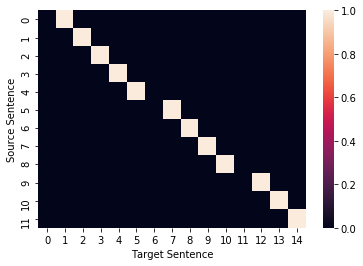

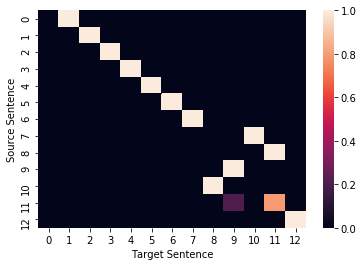

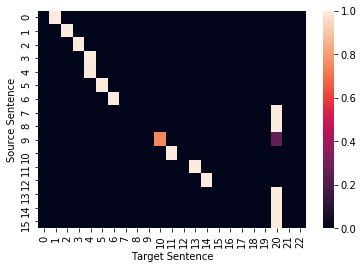

In [ ]:
import seaborn as sns
for i in range(1,4):
    plt.subplots()
    source = [validation_data[i].src]
    source = make_batch(source)
    target = [validation_data[i].trg]
    target = make_batch(target)
    encoder_output, encoder_mask, encoder_hidden = attention_model.encode(source)
    decoder_input, decoder_target = target[:-1], target[1:]
    logits, decoder_hidden, attention_weights = attention_model.decode(decoder_input, encoder_hidden, encoder_output, encoder_mask)
    attention_weights = attention_weights.detach().cpu().numpy().squeeze()
    sns.heatmap(attention_weights)
    plt.xlabel('Target Sentence')
    plt.ylabel('Source Sentence')
    print('\nSource: {}'.format(validation_data[i].src))
    print('Target: {}'.format(validation_data[i].trg))
    print()

Generally, it seems that the attention gives all of the weight to encoder and decoder hidden states that have approximately the same place in the sentence.This results in an almost identity-like attention matrix. 
<br><br>In some cases however, we can see the weight beginning to spread further from the diagonal, implying that certain dependencies between words arise in different orders. 
<br><br>
For example, the end of the second source sentence is: "den Schultern einer Frau" which correspond to the target "a woman's shoulders". As the genitive takes a different form in english and in german, we can see the attention mechanism is attributing weights to words in a different order than the identity matrix.
<br><br>
Additionally, some words and adjectives can be combined into one in german (Eisfischerhütte -> ice fishing hut), which results in zero entries in the attention weights. There is also syntactic dependencies at the end of the sentence that require looking at the words in a different order.
<br><br>
Mostly, the observed differences come from syntactic differences between both languages.